In [31]:
import torchvision.models as models
import torch.nn as nn,pandas as pd,torch
from torchvision import transforms
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from regDataset import binary_acc,RegDataset
# from regModels import RegModel,RegModelSeperateBlocks
import os,shutil
import cv2 as cv
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score,classification_report
import seaborn as sns

In [2]:
dfTest = pd.read_csv("/home/pictor/workspace/Akhil/Confidence/Data/RegData/TestReg.csv")
threshold = 0.8
metricCol = 'IoU'
label_function = lambda x: 0 if x<threshold else 1
dfTest.loc[:,'label'] = dfTest[metricCol].apply(label_function)
dfTest.head()

Unnamed: 0       IoU  accuracy  \
0       14803  0.529264  0.939565   
1       14805  0.764624  0.961272   
2       14806  0.000000  0.862231   
3       14808  0.878936  0.982976   
4       14810  0.136580  0.415025   

                                            predMask  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                              gtMask  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                            RecInput  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                            InputImg  Epoch  Data  label  
0  /home/pictor/workspace/Akhil/Confidence/Data/R...    161  Test      0  
1  /home/pictor/workspace/Akhil/Confidence/Data/R...    101  Test      0  
2  /home/pictor/workspace/Akhil/Confidence/Data/R...     71  Test      0  
3  /home/pictor/workspace/Akhil/Confidence/Data/R...     91  Test      1  
4  /home/pictor/workspace/Akhil/Confidence/Data/R...      1  Test      0

In [3]:
dfTest.label.value_counts(1)

0    0.522751
1    0.477249
Name: label, dtype: float64

In [4]:
model_path = "/home/pictor/workspace/Akhil/Confidence/codes/regModels/RegModelOnlyInputandMask.pt"
im_size = 512
batch_size = 1

In [5]:
device = torch.device("cuda")#"cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
preprocess_rgb = transforms.Compose([
    transforms.Resize((im_size,im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
preprocess_grayscale = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((im_size,im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,), std=(0.229,)),
])

In [7]:
test_dataset = RegDataset(dfTest,
                            transform={'preprocess_rgb':preprocess_rgb,'preprocess_grayscale':preprocess_grayscale},
                            labelCol='label',device=device)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)

In [8]:
model = torch.load(model_path)
model.to(device)
lossFn = nn.CrossEntropyLoss()
model.eval()
y_pred_val = []
Y = []
with torch.no_grad():
    for val_batch in tqdm(test_dataloader):
        y_pred_val.append(model(val_batch))
        Y.append(val_batch['Y'])

y_pred_val = torch.vstack(y_pred_val)
Y = torch.vstack(Y).flatten()

  0%|          | 0/2835 [00:00<?, ?it/s]/home/pictor/.virtualenvs/ml_g6/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 2835/2835 [03:12<00:00, 14.75it/s]


In [17]:
Y=Y.to(device)

In [19]:
test_loss = lossFn(y_pred_val,Y)
test_acc = binary_acc(y_pred_val,Y)

In [20]:
print(f'Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.3f}|')

Test Loss: 0.41735 | Train Acc: 81.000|


In [23]:
ypred_prob = torch.exp(torch.log_softmax(y_pred_val, dim = 1))
_,labelPred = torch.max(ypred_prob,dim=1)
dfTest.loc[:,'pred'] = labelPred.to("cpu")
dfTest.loc[:,'confidence'] = ypred_prob[:,1].to("cpu")

In [24]:
tempDf183 = dfTest[dfTest.Epoch==183]
tempDf183.shape

(151, 12)

In [36]:
print("Accuray on Epoch 183 - ",accuracy_score(tempDf183.pred,tempDf183.label))

Accuray on Epoch 183 -  0.8013245033112583


In [26]:
roc_auc_score(dfTest.label,dfTest.confidence)

0.898395927279111

In [27]:
roc_auc_score(tempDf183.label,tempDf183.confidence)

0.8601232811759127

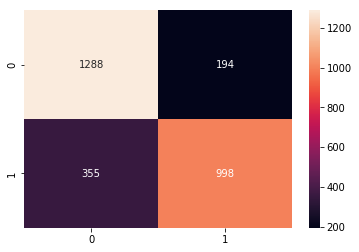

In [28]:
sns.heatmap(confusion_matrix(dfTest.label,dfTest.pred),annot=True,fmt='d');

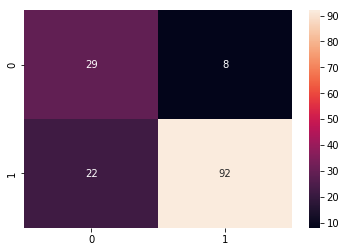

In [29]:
sns.heatmap(confusion_matrix(tempDf183.label,tempDf183.pred),annot=True,fmt='d');

In [34]:
print(classification_report(dfTest.label,dfTest.pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1482
           1       0.84      0.74      0.78      1353

    accuracy                           0.81      2835
   macro avg       0.81      0.80      0.80      2835
weighted avg       0.81      0.81      0.81      2835



In [33]:
print(classification_report(tempDf183.label,tempDf183.pred))

              precision    recall  f1-score   support

           0       0.57      0.78      0.66        37
           1       0.92      0.81      0.86       114

    accuracy                           0.80       151
   macro avg       0.74      0.80      0.76       151
weighted avg       0.83      0.80      0.81       151



In [30]:
prob = dfTest.confidence
for thr in [0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.8,0.9]:
    yp_temp = [1 if i>thr else 0 for i in prob]
    print(f"Thresh - {thr}, Acc - {accuracy_score(dfTest.label,yp_temp)}")

Thresh - 0.3, Acc - 0.8151675485008818
Thresh - 0.4, Acc - 0.818342151675485
Thresh - 0.5, Acc - 0.8063492063492064
Thresh - 0.55, Acc - 0.799294532627866
Thresh - 0.6, Acc - 0.7802469135802469
Thresh - 0.65, Acc - 0.7530864197530864
Thresh - 0.7, Acc - 0.7266313932980599
Thresh - 0.8, Acc - 0.653968253968254
Thresh - 0.9, Acc - 0.5749559082892416


In [ ]:
perfDict = {
    'TP':{'label':1,'pred':1},
    'FP':{'label':0,'pred':1},

    'TN':{'label':0,'pred':0},
    'FN':{'label':1,'pred':0},
}

In [ ]:
outPath = "/home/pictor/workspace/Akhil/Confidence/Data/Results"
for lbl in perfDict:
    gtLbl,prdLbl = perfDict[lbl]['label'],perfDict[lbl]['pred']
    tmp = tempDf183[(tempDf183.label==gtLbl)&(tempDf183.pred==prdLbl)]
    dir = os.path.join(outPath,lbl)
    os.makedirs(dir,exist_ok=True)
    for inptImgPth,gtMskPth,RecPth,predMskPth in tmp[['InputImg','gtMask','RecInput','predMask']].values:
        shutil.copy2(inptImgPth,dir)
        shutil.copy2(RecPth,dir)
        shutil.copy2(predMskPth,dir)
        img = cv.imread(gtMskPth)
        img[img==1]=255
        img[img==2]=0
        cv.imwrite(os.path.join(dir,os.path.basename(gtMskPth).replace('tif','png')),img)
    tmp.to_csv(os.path.join(dir,'pred.csv'),index=False)

In [ ]:
tmp

Unnamed: 0       IoU  accuracy  \
13         14820  0.878864  0.982993   
33         14840  0.860784  0.981156   
53         14860  0.945303  0.991700   
72         14879  0.929349  0.989824   
91         14899  0.889678  0.985545   
...          ...       ...       ...   
2734       17717  0.876909  0.978501   
2773       17757  0.966003  0.991507   
2792       17777  0.907610  0.984634   
2812       17797  0.851636  0.977963   
2832       17817  0.917175  0.994770   

                                               predMask  \
13    /home/pictor/workspace/Akhil/Confidence/Data/R...   
33    /home/pictor/workspace/Akhil/Confidence/Data/R...   
53    /home/pictor/workspace/Akhil/Confidence/Data/R...   
72    /home/pictor/workspace/Akhil/Confidence/Data/R...   
91    /home/pictor/workspace/Akhil/Confidence/Data/R...   
...                                                 ...   
2734  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2773  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2792  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2812  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2832  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                                 gtMask  \
13    /home/pictor/workspace/Akhil/Confidence/Data/R...   
33    /home/pictor/workspace/Akhil/Confidence/Data/R...   
53    /home/pictor/workspace/Akhil/Confidence/Data/R...   
72    /home/pictor/workspace/Akhil/Confidence/Data/R...   
91    /home/pictor/workspace/Akhil/Confidence/Data/R...   
...                                                 ...   
2734  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2773  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2792  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2812  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2832  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                               RecInput  \
13    /home/pictor/workspace/Akhil/Confidence/Data/R...   
33    /home/pictor/workspace/Akhil/Confidence/Data/R...   
53    /home/pictor/workspace/Akhil/Confidence/Data/R...   
72    /home/pictor/workspace/Akhil/Confidence/Data/R...   
91    /home/pictor/workspace/Akhil/Confidence/Data/R...   
...                                                 ...   
2734  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2773  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2792  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2812  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2832  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                               InputImg  Epoch  Data  label  \
13    /home/pictor/workspace/Akhil/Confidence/Data/R...    183  Test      1   
33    /home/pictor/workspace/Akhil/Confidence/Data/R...    183  Test      1   
53    /home/pictor/workspace/Akhil/Confidence/Data/R...    183  Test      1   
72    /home/pictor/workspace/Akhil/Confidence/Data/R...    183  Test      1   
91    /home/pictor/workspace/Akhil/Confidence/Data/R...    183  Test      1   
...                                                 ...    ...   ...    ...   
2734  /home/pictor/workspace/Akhil/Confidence/Data/R...    183  Test      1   
2773  /home/pictor/workspace/Akhil/Confidence/Data/R...    183  Test      1   
2792  /home/pictor/workspace/Akhil/Confidence/Data/R...    183  Test      1   
2812  /home/pictor/workspace/Akhil/Confidence/Data/R...    183  Test      1   
2832  /home/pictor/workspace/Akhil/Confidence/Data/R...    183  Test      1   

      pred  confidence  
13       1    0.836908  
33       1    0.710920  
53       1    0.904475  
72       1    0.850269  
91       1    0.715589  
...    ...         ...  
2734     1    0.698619  
2773     1    0.967274  
2792     1    0.896448  
2812     1    0.755267  
2832     1    0.817001  

[102 rows x 12 columns]